In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
import math

## Importing the drivingProfile

In [2]:
drivingProfile = pd.read_csv('./parameter.csv')

In [3]:
drivingProfile

,m,lf,lr,Cf,Cr,Iz,mu,steering_ratio,Sampling Period
0,1331,0.84,1.63,90624,90624,1500,0.5,0.0625,0.04


In [4]:
m = drivingProfile['m'][0]
lf = drivingProfile['lf'][0]
lr = drivingProfile['lr'][0]
Cf = drivingProfile['Cf'][0]
Cr = drivingProfile['Cr'][0]
Iz = drivingProfile['Iz'][0]
steering_ratio = drivingProfile['steering_ratio'][0]
Ts = drivingProfile['Sampling Period'][0]

## Importing inputs

In [5]:
inputs = pd.read_csv('./HighFrq_input.csv')
inputs.head()

,Time,Drv_DeltaSteer,Veh_Vx
0,0.000,0.0,19.444444
1,0.005,0.0,19.444285
2,0.010,0.0,19.443796
3,0.015,0.0,19.443005
4,0.020,0.0,19.441990


In [6]:
Time = inputs['Time'].to_numpy()

print(Time)
print(len(Time))

deltaSteer = inputs['Drv_DeltaSteer'].to_numpy()

print(deltaSteer)
print(len(deltaSteer))

Vx = inputs['Veh_Vx'].to_numpy()

print(Vx)
print(len(Vx))

[0.0000e+00 5.0000e-03 1.0000e-02 ... 2.2990e+01 2.2995e+01 2.3000e+01]
4601
[0. 0. 0. ... 0. 0. 0.]
4601
[19.44444444 19.44428528 19.44379573 ...  4.47979181  4.47811074
  4.47643096]
4601


In [7]:
n = math.floor(Ts/(Time[1]-Time[0]))
n

8

In [8]:
time = [Time[i] for i in range(len(Time)) if i%n==0]
steeringAngle = [deltaSteer[i] for i in range(len(deltaSteer)) if i%n==0]
velocity = [Vx[i] for i in range(len(Vx)) if i%n==0]

## Function to calculate parameters

In [9]:
def calculate_parameters(v_x):
  A = np.array([[(-2*Cf-2*Cr)/(m*v_x), -1-((2*Cf*lf - 2*Cr*lr)/(m*v_x*v_x))], [((2*Cr*lr)-(2*Cf*lf))/Iz, (-2*Cf*lf*lf-2*Cr*lr*lr)/(Iz*v_x)]])
  B = np.array([[(2*Cf)/(m*v_x), 0], [(2*Cf*lf)/Iz, 1/Iz]])
  C = np.array([[0, 1], [(-2*Cf-2*Cr)/m, -(2*Cf*lf-2*Cr*lr)/(m*v_x)]])
  D = np.array([[0, 0], [(2*Cf)/m, 0]])

  return [A, B, C, D]

## Controller Gain K

In [10]:
K = np.array([[1.8639, -0.0279],[-542794.8896, 32604.6225]])

## Observer Gain L

In [11]:
L = np.array([[-0.000000000009229, -0.000000000131049],[0.000000000135782, 0.000000001407986]])

## Matrix P
Positive definite P such that:  
![](./Screenshot%202023-05-30%20104347.png)  
`Amin, Amax` => Discrete-time closed loop matrices derived using the system equations fror v = vmin and v = vmax respectively.

In [12]:
P = np.array([[2, 1],[1,1]])
P

array([[2, 1],
       [1, 1]])

## Evaluating the system

In [13]:
u = [np.transpose(np.array([[deltaSteer[0]*math.pi/180, 0]]))]
x = [np.dot(np.linalg.inv(-K), u[0])]
x_cap = [np.dot(np.linalg.inv(-K), u[0])]
A, B, C, D = calculate_parameters(max(Vx))
y = [np.dot(C,x[0])]
y_cap = [np.dot(C,x_cap[0])]

for i in range(1, len(velocity)):
  A, B, C, D = calculate_parameters(velocity[i-1])

  out = signal.StateSpace(A, B, C, D)
  out = out.to_discrete(Ts)

  r = y[i-1] - y_cap[i-1]

  x.append(np.array(np.dot(out.A, x[i-1])+np.dot(out.B, u[i-1])))
  x_cap.append(np.array(np.dot(out.A, x[i-1])+np.dot(out.B, u[i-1]))+np.dot(L,r))

  y.append(np.dot(out.C, x[i-1])+np.dot(out.D, u[i-1]))
  y_cap.append(np.dot(out.C, x_cap[i-1])+np.dot(out.D, u[i-1]))

  utemp = np.dot(-K, x[i])
  utemp[0][0] += steeringAngle[i]*(math.pi/180)*steering_ratio
  u.append(utemp)

## Extracting the values from the lists

### Extracting `yaw moment -> Mz` and `steering angle -> delta` from `u[]`

In [14]:
Mz = []
delta = []
for i in range(len(u)):
    Mz.append(u[i][1][0])
    delta.append(u[i][0][0])
print(len(Mz), len(delta))
print(Mz)
print(delta)

576 576
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1199.9645745010994, 1560.7494825834362, 2000.7348352305978, 1813.898642036675, 1580.1503165715662, 918.065

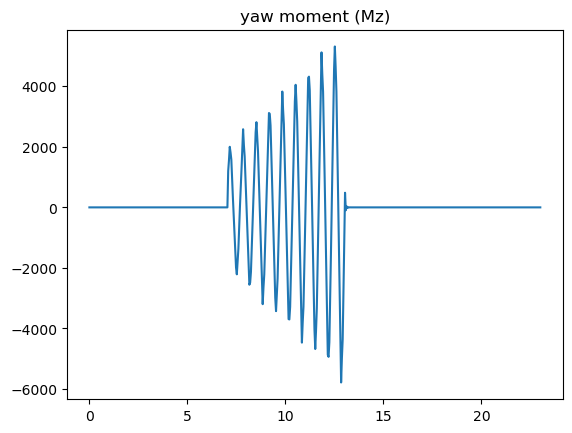

Text(0.5, 1.0, 'steering angle (delta)')

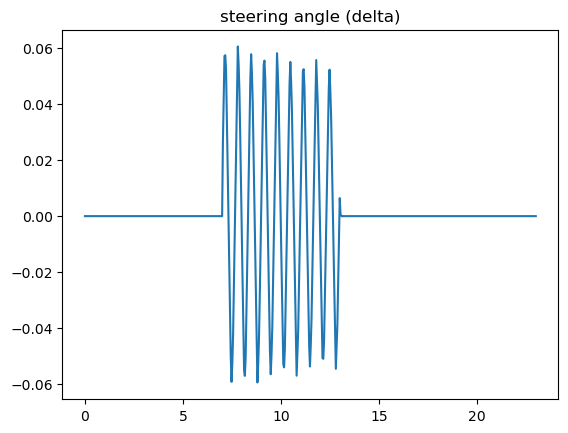

In [15]:
plt.plot(time, Mz)
plt.title("yaw moment (Mz)")
plt.show()
plt.plot(time, delta)
plt.title("steering angle (delta)")

### Extracting `sideslip angle -> beta` and `yaw rate -> r` from `x[] and x_cap[]`

In [16]:
'''
0 -> beta
1 -> r
'''
r = []
beta = []

for i in range(len(x)):
    r.append(x[i][1][0])
    beta.append(x[i][0][0])

print(len(beta), len(r))
print(beta)
print(r)

576 576
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.006646077742782676, 0.013038486260459111, 0.018816941827680976, 0.020874866360798192, 0.0202521791292401

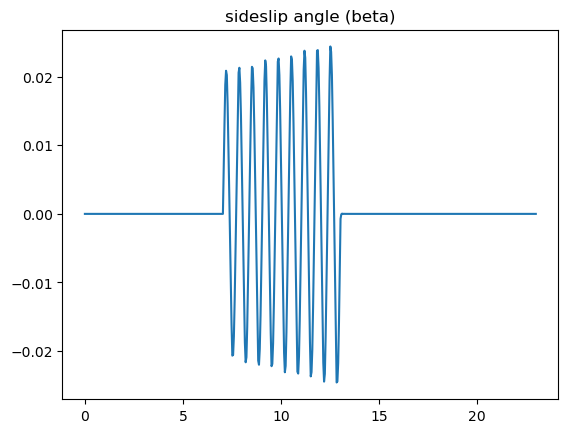

Text(0.5, 1.0, 'yaw rate (r)')

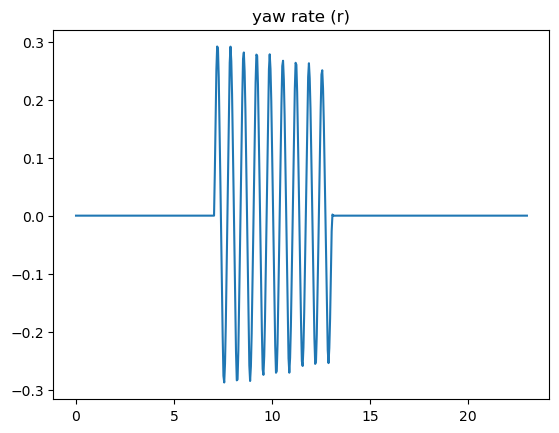

In [17]:
plt.plot(time, beta)
plt.title("sideslip angle (beta)")
plt.show()
plt.plot(time, r)
plt.title("yaw rate (r)")

In [18]:
'''
0 -> beta
1 -> r
'''
r_cap = []
beta_cap = []

for i in range(len(x)):
    r_cap.append(x_cap[i][1][0])
    beta_cap.append(x_cap[i][0][0])

print(len(beta_cap), len(r_cap))
print(beta_cap)
print(r_cap)

576 576
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.006646077742782676, 0.013038486260459111, 0.018816941827680976, 0.020874866360798192, 0.0202521791292401

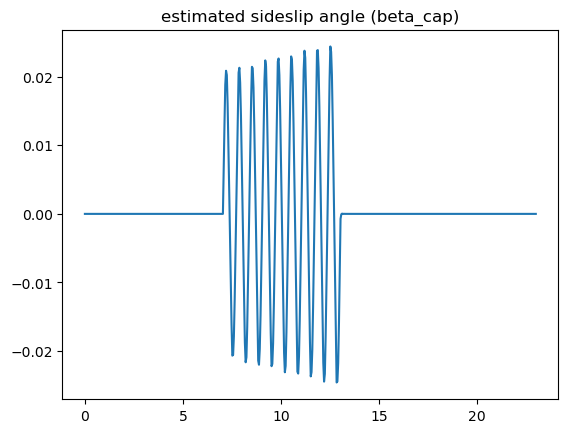

Text(0.5, 1.0, 'estaimated yaw rate (r_cap)')

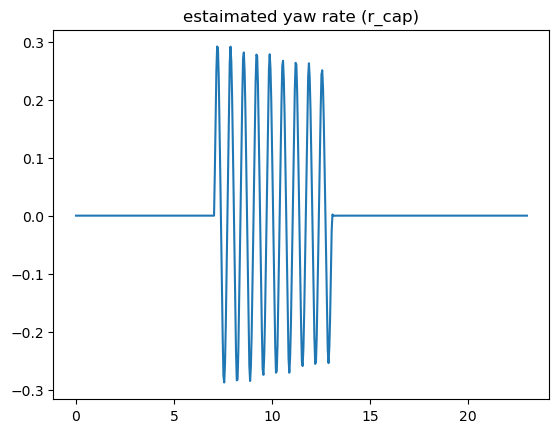

In [19]:
plt.plot(time, beta)
plt.title("estimated sideslip angle (beta_cap)")
plt.show()
plt.plot(time, r)
plt.title("estaimated yaw rate (r_cap)")

### Extracting `yaw rate -> r` and `inertial acceleration -> ay` from `y[] and y_cap[]`

In [20]:
'''
0 -> r
1 -> ay
'''
r1 = []
ay = []

for i in range(len(y)):
    r1.append(y[i][0][0])
    ay.append(y[i][1][0])

print(len(r1), len(ay))
print(r1)
print(ay)

576 576
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07383899200690455, 0.1691930102154559, 0.2518969519348098, 0.29188720524789186, 0.2886900168233437,

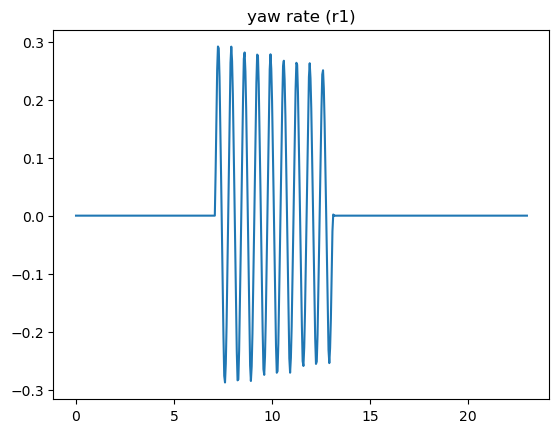

Text(0.5, 1.0, 'inertial acceleration (ay)')

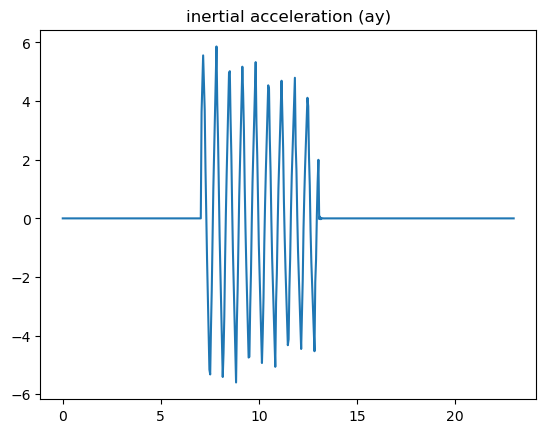

In [21]:
plt.plot(time, r1)
plt.title("yaw rate (r1)")
plt.show()
plt.plot(time, ay)
plt.title("inertial acceleration (ay)")

In [22]:
'''
0 -> r1
1 -> ay
'''
r1_cap = []
ay_cap = []

for i in range(len(y_cap)):
    r1_cap.append(y_cap[i][1][0])
    ay_cap.append(y_cap[i][0][0])

print(len(r1_cap), len(ay_cap))
print(r1_cap)
print(ay_cap)

576 576
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.6244522186689636, 4.604179862565717, 5.558804624192359, 4.666602507507633, 3.7033854525180154, 1.6810086

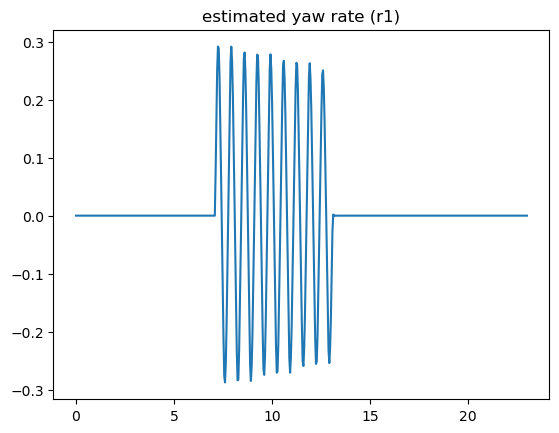

Text(0.5, 1.0, 'estimated inertial acceleration (ay)')

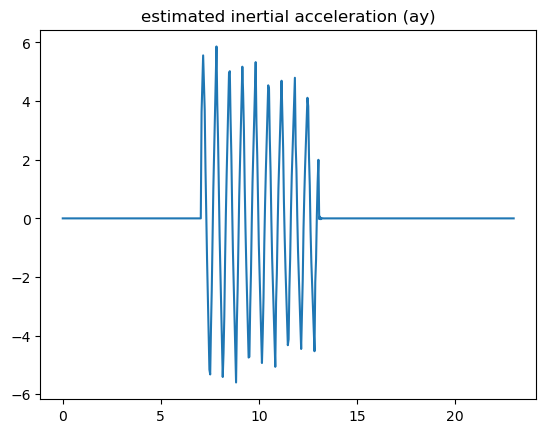

In [23]:
plt.plot(time, r1)
plt.title("estimated yaw rate (r1)")
plt.show()
plt.plot(time, ay)
plt.title("estimated inertial acceleration (ay)")

---

In [24]:
print(f"Inputs: \n{u}, \n\n\nOutputs: \n{y}")

Inputs: 
[array([[0.],
       [0.]]), array([[0.],
       [0.]]), array([[0.],
       [0.]]), array([[0.],
       [0.]]), array([[0.],
       [0.]]), array([[0.],
       [0.]]), array([[0.],
       [0.]]), array([[0.],
       [0.]]), array([[0.],
       [0.]]), array([[0.],
       [0.]]), array([[0.],
       [0.]]), array([[0.],
       [0.]]), array([[0.],
       [0.]]), array([[0.],
       [0.]]), array([[0.],
       [0.]]), array([[0.],
       [0.]]), array([[0.],
       [0.]]), array([[0.],
       [0.]]), array([[0.],
       [0.]]), array([[0.],
       [0.]]), array([[0.],
       [0.]]), array([[0.],
       [0.]]), array([[0.],
       [0.]]), array([[0.],
       [0.]]), array([[0.],
       [0.]]), array([[0.],
       [0.]]), array([[0.],
       [0.]]), array([[0.],
       [0.]]), array([[0.],
       [0.]]), array([[0.],
       [0.]]), array([[0.],
       [0.]]), array([[0.],
       [0.]]), array([[0.],
       [0.]]), array([[0.],
       [0.]]), array([[0.],
       [0.]]), array([[0.

In [25]:
inputs = [[], []]

for i in range(len(u)):
    inputs[0].append(u[i][0][0])
    inputs[1].append(u[i][1][0])

inputs = np.array(inputs)

In [26]:
print(inputs)

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  1.38708566e-66
  -9.62116886e-67  6.68147710e-67]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.49383623e-61
   3.11516575e-61 -2.16205850e-61]]


In [27]:
outputs = [[], []]

for i in range(len(y)):
    outputs[0].append(y[i][0][0])
    outputs[1].append(y[i][1][0])

outputs = np.array(outputs)

In [28]:
outputs.shape

(2, 576)

# Inserting noise to the output data

In [29]:
from sippy import functionset as fset

In [30]:
size = len(inputs[0])
noise = fset.white_noise_var(size, [0.001, 0.01])

In [31]:
noise.shape

(2, 576)

In [32]:
outputs.shape

(2, 576)

In [33]:
netOuput = outputs + noise

In [34]:
netOuput.shape

(2, 576)

---

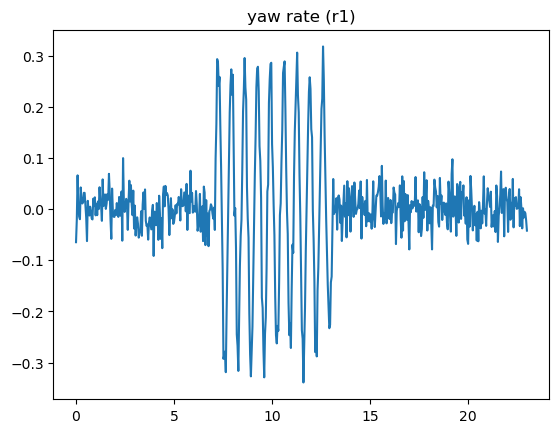

Text(0.5, 1.0, 'inertial acceleration (ay)')

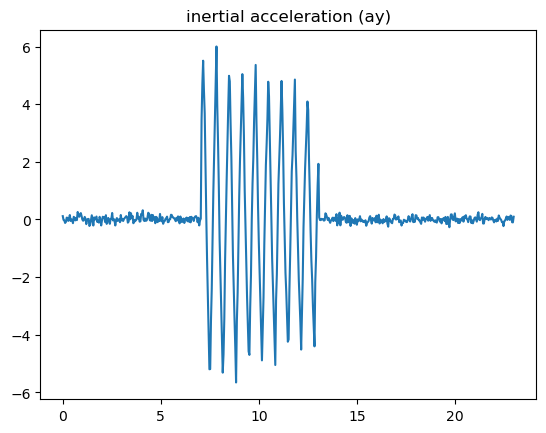

In [35]:
plt.plot(time, netOuput[0])
plt.title("yaw rate (r1)")
plt.show()
plt.plot(time, netOuput[1])
plt.title("inertial acceleration (ay)")

---
---

# SYSTEM IDENTIFICATION USING **SIPPY**

In [36]:
from sippy import system_identification
from sippy import functionset as fset
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

## Using State-Space form

In [37]:
METHOD = [
    'N4SID',
    'CVA', 
    'MOESP', 
    'PARSIM-S', 
    'PARSIM-P', 
    'PARSIM-K'
    ]

lege = ['System']

In [38]:
sysId = system_identification(netOuput, inputs, METHOD[1])

In [39]:
from sippy import functionsetSIM as fsetSIM

In [40]:
x_id, y_id = fsetSIM.SS_lsim_process_form(sysId.A, sysId.B, sysId.C, sysId.D, inputs, sysId.x0)

In [41]:
sysId.A.shape

(20, 20)

Text(0.5, 1.0, 'yaw rate r')

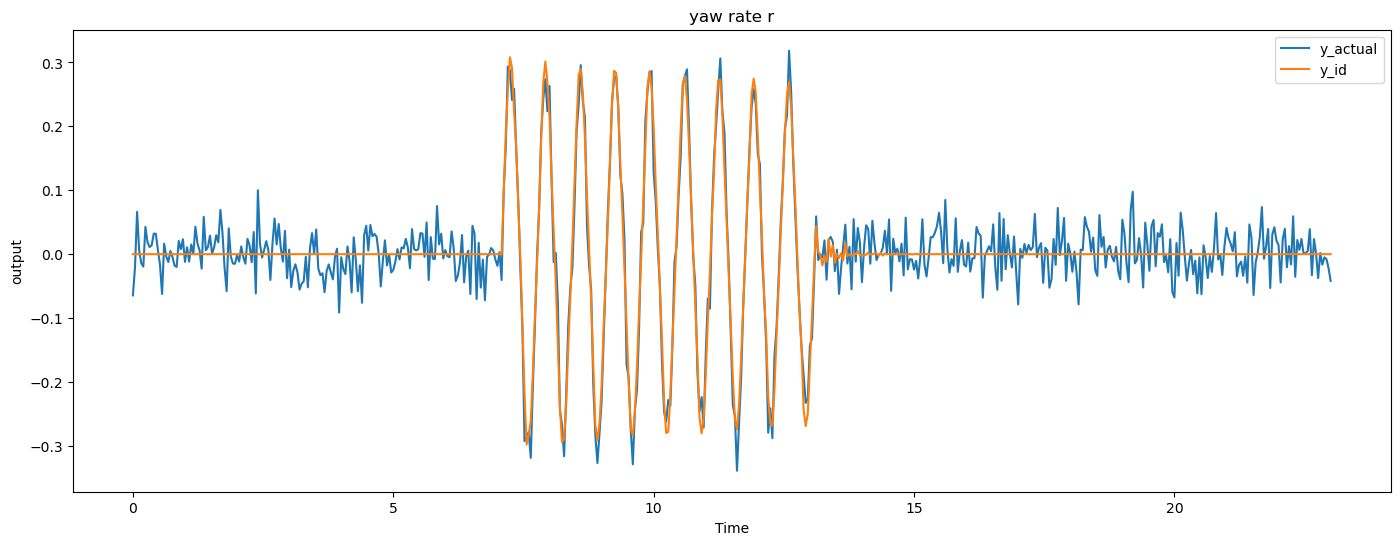

In [42]:
plt.figure(figsize=(17, 6))
plt.plot(time, netOuput[0], label='y_actual')
plt.plot(time, y_id[0], label='y_id')
plt.legend()
plt.xlabel('Time')
plt.ylabel('output')
plt.title('yaw rate r')

Text(0.5, 1.0, 'inertial acceleration ay')

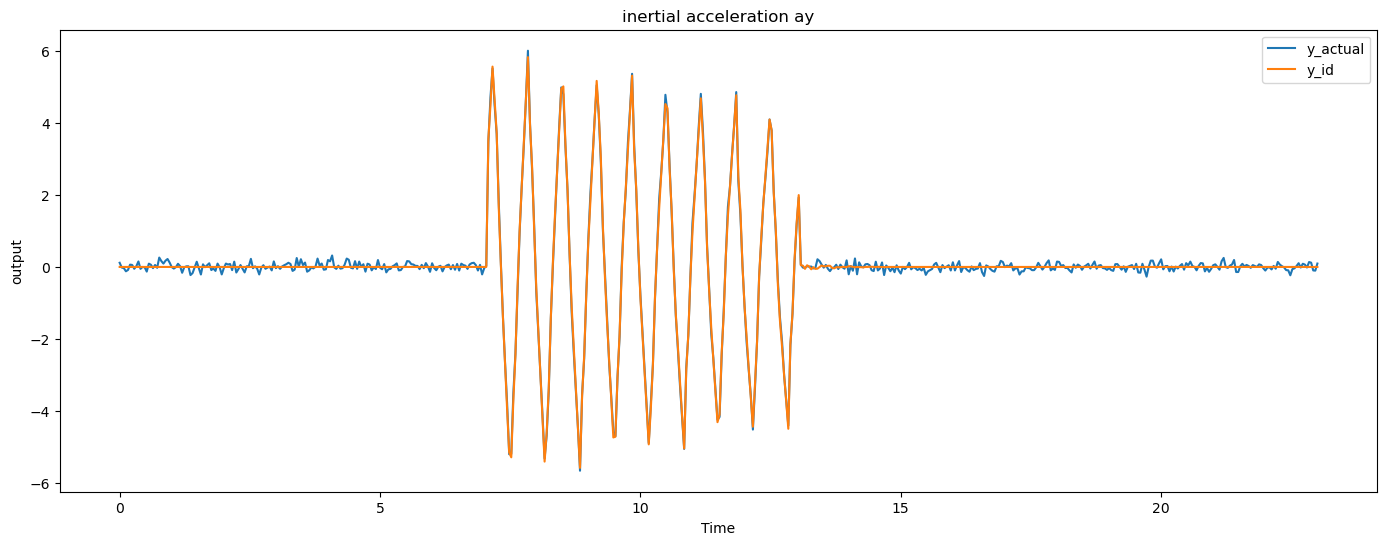

In [43]:
plt.figure(figsize=(17, 6))
plt.plot(time, netOuput[1], label='y_actual')
plt.plot(time, y_id[1], label = 'y_id')
plt.legend()
plt.xlabel('Time')
plt.ylabel('output')
plt.title('inertial acceleration ay')

In [44]:
# for yaw rate
r2_score(netOuput[0], y_id[0])

0.9044716585890522

In [45]:
# for inertial acceleration ay
r2_score(netOuput[1], y_id[1])

0.9960797420412116

---

In [46]:
# for yaw rate
math.sqrt(mean_squared_error(netOuput[0], y_id[0]))

0.03174402112574749

In [47]:
# for inertial acceleration ay
math.sqrt(mean_squared_error(netOuput[0], y_id[0]))

0.03174402112574749